# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 9

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"] / "phenoplier" / "gls-1000g_mashr-test-full_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-test-full_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"
# PVALUE_COLUMN = "pvalue"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lv = results["lv"].unique()
    assert len(observed_lv) == 1
    observed_lv = observed_lv[0]

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-test-full_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-test-full_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-test-full_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-test-full_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-1000g_mashr-test-full_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(9000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV45,0.013412,0.085388,0.157067,8.751971e-01,4.375985e-01,random.pheno988
1,LV234,-0.001331,0.002044,-0.651060,5.150308e-01,7.424846e-01,random.pheno988
2,LV847,-3.217471,0.020614,-156.084145,0.000000e+00,1.000000e+00,random.pheno988
3,LV110,-2.247507,0.010240,-219.487218,0.000000e+00,1.000000e+00,random.pheno988
4,LV769,0.030128,0.004403,6.842449,8.503523e-12,4.251761e-12,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.39466666666666667

It should be around 0.05. Let's check what happened at individual LVs.

# Summary of mean type I error per LV

In [18]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [19]:
summary_df.shape

(9, 4)

In [20]:
summary_df.head()

,lv,1,5,10
0,LV110,0.410,0.410,0.410
1,LV234,0.000,0.000,0.000
2,LV412,0.584,0.585,0.586
3,LV45,0.005,0.015,0.029
4,LV57,0.414,0.414,0.415


In [21]:
summary_df.describe()

,1,5,10
count,9.000000,9.000000,9.000000
mean,0.391222,0.394667,0.397333
std,0.232699,0.232488,0.230495
min,0.000000,0.000000,0.000000
25%,0.410000,0.410000,0.410000
50%,0.414000,0.414000,0.415000
75%,0.578000,0.579000,0.579000
max,0.584000,0.585000,0.586000


## LVs with expected type I error

In [22]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(0, 4)

,lv,1,5,10


,lv,1,5,10


## LVs with high type I error

In [23]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(7, 4)

,lv,1,5,10
0,LV110,0.410,0.410,0.410
8,LV847,0.410,0.410,0.410
4,LV57,0.414,0.414,0.415
6,LV769,0.541,0.557,0.564
5,LV647,0.579,0.579,0.579
7,LV800,0.578,0.582,0.583
2,LV412,0.584,0.585,0.586


Many LVs have a mean type I error greater than expected.

LV45 has the largest mean type I error (0.158). Let's take a look at these LVs with poor mean type I errors.

# LVs with high mean type I error

In [24]:
lv_results_high = {}

## LV45

In [25]:
lv_code = "LV45"

In [26]:
results = dfs[dfs["lv"] == lv_code]

In [27]:
results.shape

(1000, 7)

In [28]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV45,0.013412,0.085388,0.157067,0.875197,0.437599,random.pheno988
9,LV45,0.001896,0.028818,0.065789,0.947547,0.473774,random.pheno589
18,LV45,0.012722,0.044734,0.284403,0.776111,0.388055,random.pheno385
27,LV45,-0.003143,0.014012,-0.224341,0.822499,0.588750,random.pheno5
36,LV45,-0.015456,0.023305,-0.663187,0.507234,0.746383,random.pheno74


In [29]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [30]:
show_prop(results, 0.01)

0.005

In [31]:
show_prop(results, 0.05)

0.015

In [32]:
show_prop(results, 0.10)

0.029

In [33]:
show_prop(results, 0.15)

0.049

In [34]:
show_prop(results, 0.20)

0.077

### QQplot

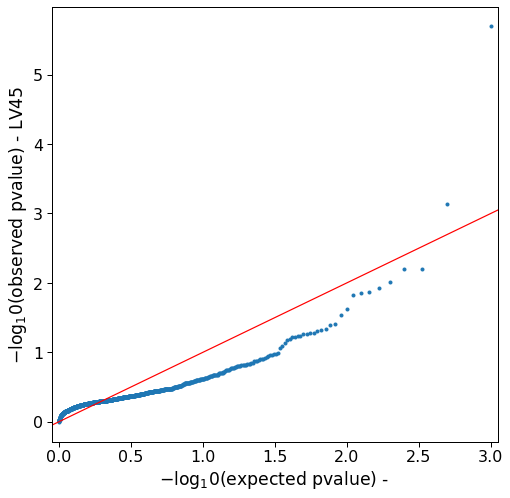

In [35]:
qqplot_unif(results)

## LV234

In [36]:
lv_code = "LV234"

In [37]:
results = dfs[dfs["lv"] == lv_code]

In [38]:
results.shape

(1000, 7)

In [39]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
1,LV234,-0.001331,0.002044,-0.651060,0.515031,0.742485,random.pheno988
10,LV234,-0.000428,0.000690,-0.620470,0.534970,0.732515,random.pheno589
19,LV234,0.000679,0.001071,0.633736,0.526276,0.263138,random.pheno385
28,LV234,0.000126,0.000335,0.376372,0.706653,0.353326,random.pheno5
37,LV234,-0.000329,0.000558,-0.590245,0.555047,0.722476,random.pheno74


In [40]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [41]:
show_prop(results, 0.01)

0.0

In [42]:
show_prop(results, 0.05)

0.0

In [43]:
show_prop(results, 0.10)

0.0

In [44]:
show_prop(results, 0.15)

0.0

In [45]:
show_prop(results, 0.20)

0.0

### QQplot

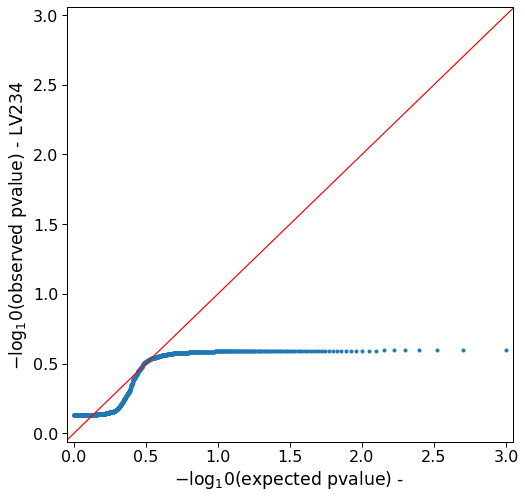

In [46]:
qqplot_unif(results)

## LV847

In [47]:
lv_code = "LV847"

In [48]:
results = dfs[dfs["lv"] == lv_code]

In [49]:
results.shape

(1000, 7)

In [50]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
2,LV847,-3.217471,0.020614,-156.084145,0.0,1.0,random.pheno988
11,LV847,-1.025093,0.008266,-124.008996,0.0,1.0,random.pheno589
20,LV847,1.610850,0.012446,129.428590,0.0,0.0,random.pheno385
29,LV847,0.310604,0.006304,49.267262,0.0,0.0,random.pheno5
38,LV847,-0.801509,0.007187,-111.516830,0.0,1.0,random.pheno74


In [51]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [52]:
show_prop(results, 0.01)

0.41

In [53]:
show_prop(results, 0.05)

0.41

In [54]:
show_prop(results, 0.10)

0.41

In [55]:
show_prop(results, 0.15)

0.411

In [56]:
show_prop(results, 0.20)

0.411

### QQplot

/tmp/ipykernel_37283/96230195.py:4: RuntimeWarning: divide by zero encountered in log10
  observed_data = -np.log10(data)


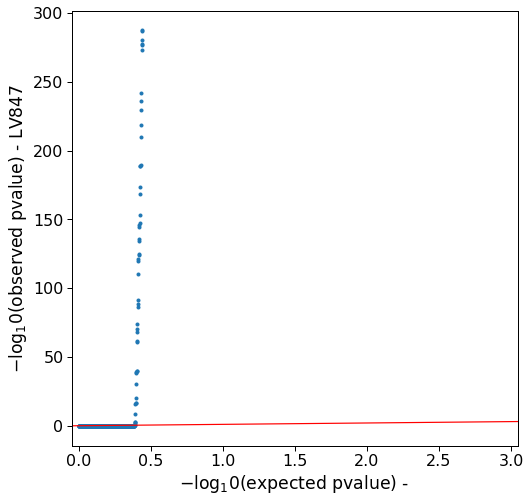

In [57]:
qqplot_unif(results)

## LV110

In [58]:
lv_code = "LV110"

In [59]:
results = dfs[dfs["lv"] == lv_code]

In [60]:
results.shape

(1000, 7)

In [61]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
3,LV110,-2.247507,0.010240,-219.487218,0.0,1.0,random.pheno988
12,LV110,-0.715604,0.004666,-153.372015,0.0,1.0,random.pheno589
21,LV110,1.122010,0.006970,160.983032,0.0,0.0,random.pheno385
30,LV110,0.217795,0.004072,53.490138,0.0,0.0,random.pheno5
39,LV110,-0.560184,0.004185,-133.840475,0.0,1.0,random.pheno74


In [62]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [63]:
show_prop(results, 0.01)

0.41

In [64]:
show_prop(results, 0.05)

0.41

In [65]:
show_prop(results, 0.10)

0.41

In [66]:
show_prop(results, 0.15)

0.41

In [67]:
show_prop(results, 0.20)

0.41

### QQplot

/tmp/ipykernel_37283/96230195.py:4: RuntimeWarning: divide by zero encountered in log10
  observed_data = -np.log10(data)


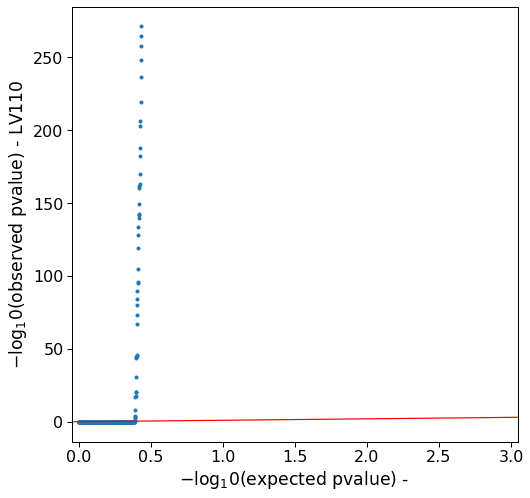

In [68]:
qqplot_unif(results)

## LV769

In [69]:
lv_code = "LV769"

In [70]:
results = dfs[dfs["lv"] == lv_code]

In [71]:
results.shape

(1000, 7)

In [72]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
4,LV769,0.030128,0.004403,6.842449,8.503523e-12,4.251761e-12,random.pheno988
13,LV769,0.010501,0.001486,7.068085,1.736450e-12,8.682249e-13,random.pheno589
22,LV769,-0.017366,0.002305,-7.533988,5.597289e-14,1.000000e+00,random.pheno385
31,LV769,-0.001838,0.000725,-2.536103,1.123280e-02,9.943836e-01,random.pheno5
40,LV769,0.007115,0.001203,5.914638,3.496644e-09,1.748322e-09,random.pheno74


In [73]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [74]:
show_prop(results, 0.01)

0.541

In [75]:
show_prop(results, 0.05)

0.557

In [76]:
show_prop(results, 0.10)

0.564

In [77]:
show_prop(results, 0.15)

0.568

In [78]:
show_prop(results, 0.20)

0.572

### QQplot

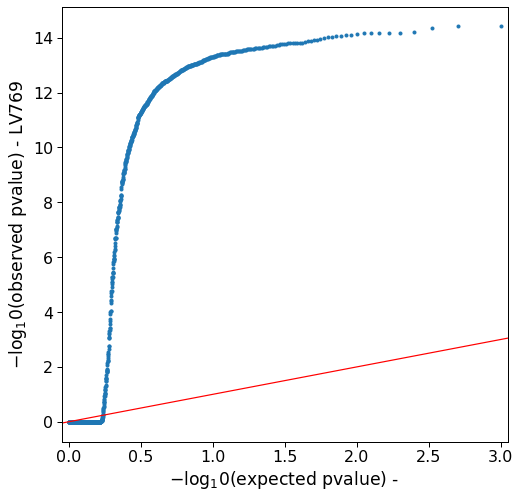

In [79]:
qqplot_unif(results)

The QQplot here is not the same as the LVs before. In previous LVs, there are very small pvalues, likely because of the genes from the same region at the top of the LV.

Here p-values are consistently smaller than expected, but there are no very small p-values.

## LV800

In [80]:
lv_code = "LV800"

In [81]:
results = dfs[dfs["lv"] == lv_code]

In [82]:
results.shape

(1000, 7)

In [83]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
5,LV800,0.103824,0.001460,71.130664,0.000000e+00,0.0,random.pheno988
14,LV800,0.035091,0.000492,71.314266,0.000000e+00,0.0,random.pheno589
23,LV800,-0.057044,0.000734,-77.709131,0.000000e+00,1.0,random.pheno385
32,LV800,-0.007658,0.000306,-25.067985,2.089598e-132,1.0,random.pheno5
41,LV800,0.025135,0.000430,58.387099,0.000000e+00,0.0,random.pheno74


In [84]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [85]:
show_prop(results, 0.01)

0.578

In [86]:
show_prop(results, 0.05)

0.582

In [87]:
show_prop(results, 0.10)

0.583

In [88]:
show_prop(results, 0.15)

0.584

In [89]:
show_prop(results, 0.20)

0.584

### QQplot

/tmp/ipykernel_37283/96230195.py:4: RuntimeWarning: divide by zero encountered in log10
  observed_data = -np.log10(data)


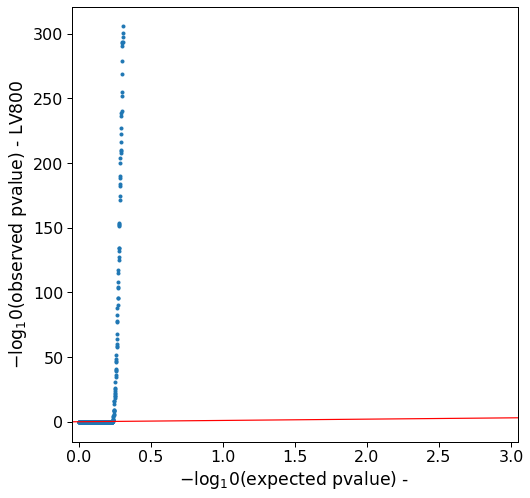

In [90]:
qqplot_unif(results)

# LVs with expected mean type I error

In [91]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10


In [92]:
lv_results_expected = {}

## LV412

In [93]:
lv_code = "LV412"

In [94]:
results = dfs[dfs["lv"] == lv_code]

In [95]:
results.shape

(1000, 7)

In [96]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
6,LV412,0.021494,0.000030,722.688998,0.0,0.0,random.pheno988
15,LV412,0.006775,0.000034,200.223612,0.0,0.0,random.pheno589
24,LV412,-0.010610,0.000050,-214.148326,0.0,1.0,random.pheno385
33,LV412,-0.002160,0.000035,-61.571601,0.0,1.0,random.pheno5
42,LV412,0.005393,0.000030,180.316670,0.0,0.0,random.pheno74


In [97]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [98]:
show_prop(results, 0.01)

0.584

In [99]:
show_prop(results, 0.05)

0.585

In [100]:
show_prop(results, 0.10)

0.586

In [101]:
show_prop(results, 0.15)

0.587

In [102]:
show_prop(results, 0.20)

0.587

### QQplot

/tmp/ipykernel_37283/96230195.py:4: RuntimeWarning: divide by zero encountered in log10
  observed_data = -np.log10(data)


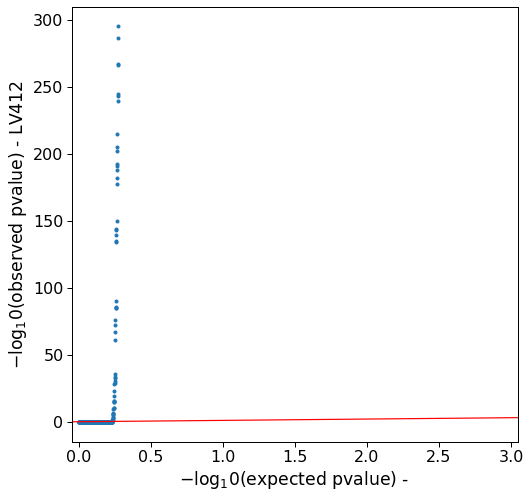

In [103]:
qqplot_unif(results)

## LV57

In [104]:
lv_code = "LV57"

In [105]:
results = dfs[dfs["lv"] == lv_code]

In [106]:
results.shape

(1000, 7)

In [107]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
7,LV57,-0.064803,0.000519,-124.756696,0.000000e+00,1.000000e+00,random.pheno988
16,LV57,-0.021881,0.000175,-124.962244,0.000000e+00,1.000000e+00,random.pheno589
25,LV57,0.035549,0.000238,149.174696,0.000000e+00,0.000000e+00,random.pheno385
34,LV57,0.004804,0.000146,32.961045,2.588893e-220,1.294447e-220,random.pheno5
43,LV57,-0.015699,0.000174,-90.020856,0.000000e+00,1.000000e+00,random.pheno74


In [108]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [109]:
show_prop(results, 0.01)

0.414

In [110]:
show_prop(results, 0.05)

0.414

In [111]:
show_prop(results, 0.10)

0.415

In [112]:
show_prop(results, 0.15)

0.415

In [113]:
show_prop(results, 0.20)

0.415

### QQplot

/tmp/ipykernel_37283/96230195.py:4: RuntimeWarning: divide by zero encountered in log10
  observed_data = -np.log10(data)


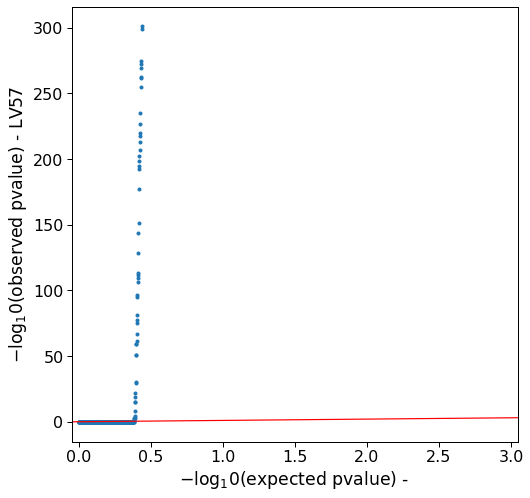

In [114]:
qqplot_unif(results)

## LV647

In [115]:
lv_code = "LV647"

In [116]:
results = dfs[dfs["lv"] == lv_code]

In [117]:
results.shape

(1000, 7)

In [118]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
8,LV647,3.125701,0.030711,101.778108,0.000000e+00,0.0,random.pheno988
17,LV647,1.079601,0.009962,108.366554,0.000000e+00,0.0,random.pheno589
26,LV647,-1.770617,0.013727,-128.984563,0.000000e+00,1.0,random.pheno385
35,LV647,-0.204730,0.007729,-26.488092,7.724989e-147,1.0,random.pheno5
44,LV647,0.750466,0.009789,76.660785,0.000000e+00,0.0,random.pheno74


In [119]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [120]:
show_prop(results, 0.01)

0.579

In [121]:
show_prop(results, 0.05)

0.579

In [122]:
show_prop(results, 0.10)

0.579

In [123]:
show_prop(results, 0.15)

0.579

In [124]:
show_prop(results, 0.20)

0.579

### QQplot

/tmp/ipykernel_37283/96230195.py:4: RuntimeWarning: divide by zero encountered in log10
  observed_data = -np.log10(data)


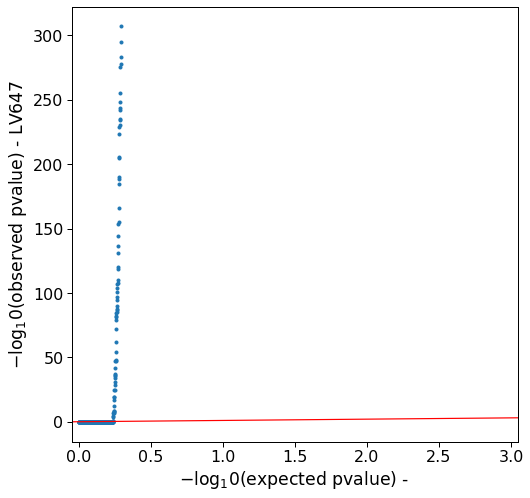

In [125]:
qqplot_unif(results)